# Generating trading signals with Linear Regression

This notebook illustrates the following steps:
1. **Cross-validation in the time-series context** poses the additional challenge that train and validation sets need to respect the temporal order of the data so that we do not inadvertently train the model on data 'from the future' to predict the past and introduce lookahead bias. Scikit-learn's built-in [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) aims to accomplish this but does not work for this case where we have multiple time series, one for each ticker. We could solve this by manually subsetting the data for the appropriate train and validation periods. Alternatively, we can create a custom time-series splitter compatible with the scikit-learn Kfold interface (see resources). Here is an [example](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/utils.py) that illustrates how to do so for this case. This allows us to specify fixed `train_length` and `test_length` parameters, as well as a `lookahead` value that defines the forecast horizon and ensures an appropriate gap between the training and validation set.
2. To establish a **baseline**, train a [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) using five years of training data to predict rolling windows of three months of returns for the years 2013-2016. Evaluate the results by computing the information coefficient (IC) as the Spearman rank correlation between the predictions and the actual returns, averaged per day.
3. Next, we'll use **regularized regression** models that include a penalty term to shrink the coefficients and limit the risk of overfitting. Cross-validate a range of `alpha` penalty values for [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) using the same training and validation periods as for the linear regression baseline and compare their performance.

> You can also upload and run this notebook in [google collab](https://colab.research.google.com/notebooks/intro.ipynb), just install the packages required by the below imports, mount you Google Drive as described [here](https://buomsoo-kim.github.io/colab/2020/05/09/Colab-mounting-google-drive.md/) and update the `DATA_PATH` to the location on your Google Drive (relative to you mount path) with the `HDFStore` containing the Quandl dataset we created in the first milestone.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

## Settings

In [3]:
sns.set_style('whitegrid')

In [4]:
np.random.seed(42)

In [5]:
idx = pd.IndexSlice

In [6]:
YEAR = 252 # days
MONTH = 21 # days

In [7]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

## Get Data

In [8]:
DATA_PATH = Path('..', 'data')

In [9]:
data = (pd.read_hdf(DATA_PATH / 'stock_prices.h5', 'model_data')
        .sort_index())

In [10]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1402295 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-07-02 00:00:00'))
Data columns (total 48 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1401795 non-null  float64
 1   ret_03       1400795 non-null  float64
 2   ret_05       1399795 non-null  float64
 3   ret_10       1397295 non-null  float64
 4   ret_21       1391795 non-null  float64
 5   ret_42       1381295 non-null  float64
 6   ret_63       1370795 non-null  float64
 7   ret_126      1339295 non-null  float64
 8   ret_252      1276295 non-null  float64
 9   ret_fwd      1402295 non-null  float64
 10  BB_UP        1392795 non-null  float64
 11  BB_LOW       1392795 non-null  float64
 12  BB_SQUEEZE   1392795 non-null  float64
 13  HT           1370795 non-null  float64
 14  SAR          1401795 non-null  float64
 15  ADX          1388795 non-null  float64
 16  ADXR         13822

To facilitate model formulation, we assign target, features, and categorical variables.

In [11]:
target = 'ret_fwd'
features = data.columns.drop(target)

In [12]:
categoricals = ['month', 'weekday']

## Custom Time Series Cross-Validation

Our data consists of numerous time series, one for each security. Sequential data like time series requires careful cross-validation to be set up so that we do not inadvertently introduce look-ahead bias or leakage.

We can achieve this using the `MultipleTimeSeriesCV` class that we introduced in Milestone 3. We initialize it with the desired lengths for the train and test periods, the number of test periods that we would like to run, and the number of periods in our forecasting horizon. The `split()` method returns a generator yielding pairs of train and test indices, which we can then use to select outcomes and features. The number of pairs depends on the parameter `n_splits`.

The test periods do not overlap and are located at the end of the period available in the data. After a test period is used, it becomes part of the training data that rolls forward and remains constant in size.

In [13]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


## Model Selection: Lookback, lookahead and roll-forward periods

We'll use five years of training data to predict the 1-day forward returns for the following three months for all models.

In [14]:
train_length = 5 * YEAR
test_length = 3 * MONTH

In [15]:
lookahead = 1

We'll create 16 quarters worth of out-of-sample predictions so we can select the past 4 quarters to select a model for a subsequent quarter with three years total of out-of-sample forecasts.

In [16]:
n_splits = 16

In [17]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_length,
                          lookahead=lookahead,
                          train_period_length=train_length)

Show rolling cross-validation periods - note that the folds move backwards in time:

In [18]:
for n_split, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    
    train_days = train.groupby(level="ticker").size().value_counts().index[0]
    train_start, train_end = train_dates.min().date(), train_dates.max().date()
    
    test_days = test.groupby(level="ticker").size().value_counts().index[0]
    test_start, test_end = test_dates.min().date(), test_dates.max().date()
                                                  
    print(f'Split: {n_split:02} | # Train: {train_start} - {train_end} ({train_days:5,.0f} days) | '
          f'Test: {test_start} - {test_end} ({test_days} days)')

Split: 00 | # Train: 2011-11-08 - 2016-09-29 (1,260 days) | Test: 2016-09-30 - 2016-12-29 (63 days)
Split: 01 | # Train: 2011-08-11 - 2016-06-30 (1,260 days) | Test: 2016-07-01 - 2016-09-29 (63 days)
Split: 02 | # Train: 2011-05-16 - 2016-04-01 (1,260 days) | Test: 2016-04-04 - 2016-06-30 (63 days)
Split: 03 | # Train: 2011-02-14 - 2015-12-30 (1,260 days) | Test: 2015-12-31 - 2016-04-01 (63 days)
Split: 04 | # Train: 2010-11-17 - 2015-09-30 (1,260 days) | Test: 2015-10-01 - 2015-12-30 (63 days)
Split: 05 | # Train: 2010-08-20 - 2015-07-01 (1,260 days) | Test: 2015-07-02 - 2015-09-30 (63 days)
Split: 06 | # Train: 2010-05-25 - 2015-04-01 (1,260 days) | Test: 2015-04-02 - 2015-07-01 (63 days)
Split: 07 | # Train: 2010-02-25 - 2014-12-30 (1,260 days) | Test: 2014-12-31 - 2015-04-01 (63 days)
Split: 08 | # Train: 2009-11-26 - 2014-09-30 (1,260 days) | Test: 2014-10-01 - 2014-12-30 (63 days)
Split: 09 | # Train: 2009-08-31 - 2014-07-03 (1,260 days) | Test: 2014-07-04 - 2014-09-30 (63 days)


## Baseline: Linear Regression

In this section, we will use linear regression with and without shrinkage to predict returns
and generate trading signals.

First, we need to create the model inputs and outputs. We will apply the basic linear, Lasso and Ridge regression models to their predictive performance.

### One-hot encoding

In [19]:
df = (pd.get_dummies(data, columns=categoricals, drop_first=True)
      .dropna()
      .sort_index())

X = df.drop(target, axis=1)
y = df[target]

### Run cross-validation

Instantiate a `LinearRegression` object

In [20]:
lr = LinearRegression()

The cross-validation loop iterates over the train and test indices provided by `MultipleTimeSeriesCV`, selects features and outcomes, trains the model, and predicts the returns for the test features. 

Train and predict for each fold, capturing the predictions.

In [21]:
%%time
lr_preds = []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    lr_preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
lr_preds = pd.concat(lr_preds)

CPU times: total: 1min 36s
Wall time: 16.5 s


In [22]:
lr_preds.to_hdf(DATA_PATH / 'predictions.h5', 'linear_regression')

### Evaluate Predictions using the Information Coefficient

Across all sample days, the IC is around 2.50%.

In [23]:
lr_ic, p = spearmanr(lr_preds.y_true, lr_preds.y_pred)
f'{lr_ic:.4f} ({p:.2%})'

'0.0248 (0.00%)'

On a daily basis - which is more relevant because we will be trading on the predictions for a given day - the IC has a fairly low mean of 0.59%.

In [24]:
daily_ic_lr = lr_preds.groupby(level='date').apply(lambda x: spearmanr(x.y_true, x.y_pred)[0])

In [25]:
f'Daily IC - Mean: {daily_ic_lr.mean():.4f} | CV: {daily_ic_lr.std()/daily_ic_lr.mean():.2f}'

'Daily IC - Mean: 0.0058 | CV: 25.14'

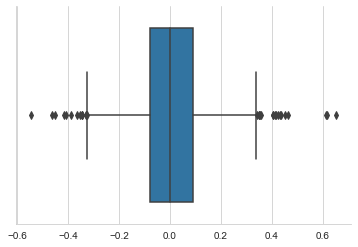

In [26]:
sns.boxplot(daily_ic_lr)
sns.despine();

## Regularized Linear Regression

We will now move on to the regularized ridge model, which we will use to evaluate whether parameter constraints improve on the linear regression's predictive performance. 

The Ridge and Lasso models allow us to select the hyperparameter `alpha` that determines the weight of the penalty term in the model's objective function.

We define a range of `alpha` penalty values, where larger values produce more regularization (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html))

In [27]:
ridge_alphas = np.logspace(-5, 15, 21)[::2]

In [28]:
ridge_alphas

array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09,
       1.e+11, 1.e+13, 1.e+15])

### Ridge Regression

The hyperparameter `alpha` implies an additional inner for loop that generates predictions for each fold and `alpha` value:

In [29]:
%%time
ridge_preds = []
scaler = MinMaxScaler()
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'{i}', end=' ', flush=True)
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_train = scaler.fit_transform(X_train)
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_test = scaler.transform(X_test)
    cv_predictions = []
    for alpha in ridge_alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    ridge_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))
ridge_preds = pd.concat(ridge_preds)
print()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
CPU times: total: 11min 12s
Wall time: 1min 8s


#### Evaluate Predictions

In [30]:
ic_by_day_ridge = {}
for alpha in ridge_alphas:
    ic_by_day_ridge[alpha] = (ridge_preds.groupby(level='date')
                              .apply(lambda x: spearmanr(x[alpha], x.y_test)[0])
                              .mean())

In [31]:
best_alpha_ridge = pd.Series(ic_by_day_ridge).idxmax()

In [32]:
best_ic_by_day_ridge = (ridge_preds.groupby(level='date')
                        .apply(lambda x: spearmanr(x[best_alpha_ridge], x.y_test)[0]))

We obtain a daily average IC of 1.25%. This results improves over the linear regression on average, while it also has lower variability.

In [33]:
print(f'Daily IC - Mean: {best_ic_by_day_ridge.mean():.4f} | '
      f'CV: {best_ic_by_day_ridge.std()/best_ic_by_day_ridge.mean():.2f}')

Daily IC - Mean: 0.0125 | CV: 11.63


The below chart shows how the daily average IC changed for different values of `alpha`, and which penalty produced the best result:

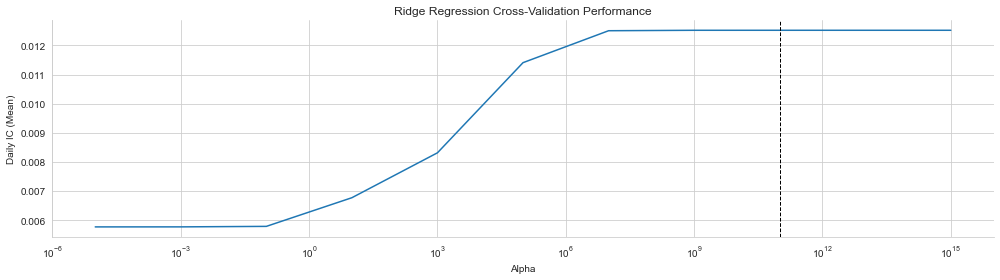

In [34]:
ax = pd.Series(ic_by_day_ridge).plot(figsize=(14, 4),
                                  logx=True, 
                                  title='Ridge Regression Cross-Validation Performance')
ax.axvline(best_alpha_ridge, c='k', ls='--', lw=1)
ax.set_ylabel('Daily IC (Mean)')
ax.set_xlabel('Alpha')
sns.despine()
plt.tight_layout();

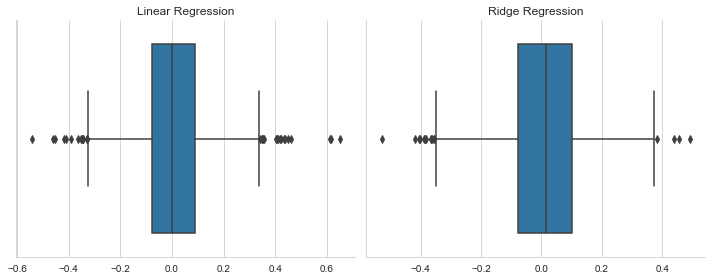

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

sns.boxplot(daily_ic_lr, ax=axes[0], orient='v')
axes[0].set_title('Linear Regression')

ridge_daily_ic = ridge_preds.groupby(level='date').apply(lambda x: spearmanr(x[best_alpha_ridge], x.y_test)[0])
sns.boxplot(ridge_daily_ic, ax=axes[1], orient='v')
axes[0].set_title('Linear Regression')
axes[1].set_title('Ridge Regression')
sns.despine()
fig.tight_layout();

#### Persist results

In [36]:
ridge_preds[best_alpha_ridge].to_hdf(DATA_PATH / 'predictions.h5', 'ridge_regression')

### Lasso Regression

The lasso implementation looks very similar to the ridge model we just ran. The main difference is that lasso needs to arrive at a solution using iterative coordinate descent, whereas ridge regression can rely on a closed-form solution. This can lead to longer training times.

In [37]:
lasso_alphas = np.logspace(-15, -5, 11)

In [38]:
lasso_preds = []
scaler = MinMaxScaler()
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'\nFold {i}')
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_train = scaler.fit_transform(X_train)
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_test = scaler.transform(X_test)    
    cv_predictions = []
    for alpha in lasso_alphas:
        print(f'{alpha:.0e}', end=' ', flush=True)
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    lasso_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))
lasso_preds = pd.concat(lasso_preds)


Fold 0
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 1
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 2
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 3
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 4
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 5
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 6
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 7
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 8
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 9
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 10
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 11
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 12
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 13
1e-15 1e-14 1e-13 1e-12 1e

#### Evaluate Predictions

In [39]:
ic_by_day_lasso = {}
for alpha in lasso_alphas:
    ic_by_day_lasso[alpha] = (lasso_preds.groupby(level='date')
                              .apply(lambda x: spearmanr(x[alpha], x.y_test)[0]).mean())

In [40]:
pd.Series(ic_by_day_lasso)

1.000000e-15    0.005771
1.000000e-14    0.005771
1.000000e-13    0.005771
1.000000e-12    0.005772
1.000000e-11    0.005772
1.000000e-10    0.005772
1.000000e-09    0.005775
1.000000e-08    0.005789
1.000000e-07    0.005927
1.000000e-06    0.007350
1.000000e-05    0.009161
dtype: float64

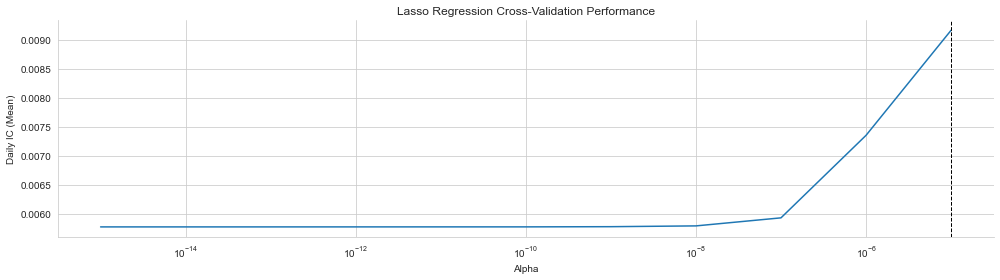

In [41]:
ax = pd.Series(ic_by_day_lasso).plot(figsize=(14, 4),
                                  logx=True, 
                                  title='Lasso Regression Cross-Validation Performance')
ax.axvline(pd.Series(ic_by_day_lasso).idxmax(), c='k', ls='--', lw=1)
ax.set_ylabel('Daily IC (Mean)')
ax.set_xlabel('Alpha')
sns.despine()
plt.tight_layout();